# setup

In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tuning_fun as tu
import emulator_fun as ef
import numpy as np
from tqdm.keras import TqdmCallback
import pandas as pd
import time
import netCDF4 as nc

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]  # in MB
#         )
#     except RuntimeError as e:
#         print(e)

2025-05-07 06:58:21.227359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746601101.244702  661525 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746601101.248981  661525 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746601101.261149  661525 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746601101.261165  661525 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746601101.261167  661525 computation_placer.cc:177] computation placer alr

# HP tuning

## pre-processing

In [2]:
case_name = 'rainshaft'
base_path = '/pscratch/sd/a/arthurhu/BOSS_PPE/summary_ncs/'
filename = case_name + '.nc'

param_all_idx = np.arange(40)
# REVIEW: check every time if this is true ... not sure how to implement this programatically
# param_interest_idx = np.arange(16,28)
param_interest_idx = np.arange(28,40)
# param_interest_idx = np.arange(0,28)
# param_interest_idx = np.arange(12)
# param_interest_idx = np.concatenate((np.arange(0,8), np.arange(16,28)))
param_not_int_idx = [i for i in param_all_idx if i not in param_interest_idx]

param_train = ef.get_params(base_path, filename, param_interest_idx)

In [3]:
nppe, npar = param_train['vals'].shape

In [4]:
dataset = nc.Dataset(base_path + filename, mode='r')

In [5]:
eff0s = getattr(dataset, 'thresholds_eff0')
var_constraints = getattr(dataset, 'var_constraints')
ppe_var_names = ['boss_' + i for i in var_constraints]
ppe_raw_vals = [dataset.variables[i][:] for i in ppe_var_names]
tgt_var_names = ['bin_' + i for i in var_constraints]
tgt_raw_vals = [dataset.variables[i][:] for i in tgt_var_names]

In [6]:
nobs = int(sum([ppe_raw_vals[i].size for i in range(len(var_constraints))])/nppe)

In [7]:
ppe_var_presence = ppe_asinh = ppe_all = np.empty((nppe,0), dtype=np.float32)
ncases = tgt_raw_vals[0].shape[0]
tgt_var_presence = tgt_asinh = tgt_all = np.empty((ncases,0), dtype=np.float32)

for idx, eff0 in enumerate(eff0s):
    if ppe_raw_vals[idx].ndim >= 2:
        ppe_raw_val_reshaped = np.reshape(ppe_raw_vals[idx], (nppe, np.prod(ppe_raw_vals[idx].shape[1:])))
        tgt_raw_val_reshaped = np.reshape(tgt_raw_vals[idx], (ncases, np.prod(tgt_raw_vals[idx].shape[1:])))
    else:
        ppe_raw_val_reshaped = ppe_raw_vals[idx].reshape(-1, 1)
        tgt_raw_val_reshaped = tgt_raw_vals[idx].reshape(-1, 1)
    ppe_var_presence = np.concatenate((ppe_var_presence, ppe_raw_val_reshaped > eff0s[idx]/100), axis=1)
    ppe_asinh_reshaped = ef.smooth_linlog(ppe_raw_val_reshaped, eff0)
    ppe_asinh = np.concatenate((ppe_asinh, ppe_asinh_reshaped), axis=1)
    tgt_var_presence = np.concatenate((tgt_var_presence, tgt_raw_val_reshaped > eff0s[idx]/100), axis=1)
    tgt_asinh_reshaped = ef.smooth_linlog(tgt_raw_val_reshaped, eff0)
    tgt_asinh = np.concatenate((tgt_asinh, tgt_asinh_reshaped), axis=1)


In [8]:
from sklearn import preprocessing
import sklearn.model_selection as mod_sec

minmaxscale = preprocessing.MinMaxScaler().fit(param_train['vals'])
x_all = minmaxscale.transform(param_train['vals'])

standscale = preprocessing.StandardScaler().fit(ppe_asinh)
ppe_all = standscale.transform(ppe_asinh)
tgt_all = standscale.transform(tgt_asinh)

In [9]:
x_train, x_val, y_train_wpresence, y_val_wpresence = mod_sec.train_test_split(x_all, ppe_var_presence, test_size=0.2, random_state=1)
_, _, y_train, y_val = mod_sec.train_test_split(x_all, ppe_all, test_size=0.2, random_state=1)

y_train = np.nan_to_num(y_train, nan=-1001)
y_val = np.nan_to_num(y_val, nan=-1001)

(array([4.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 3.240e+02, 2.472e+03,
        3.000e+02, 1.870e+02, 1.210e+02, 9.300e+01, 8.200e+01, 6.900e+01,
        8.500e+01, 1.860e+03, 9.700e+01, 1.020e+02, 1.230e+02, 1.500e+02,
        1.610e+02, 1.820e+02, 1.780e+02, 2.250e+02, 2.600e+02, 2.190e+02,
        1.880e+02, 2.120e+02, 2.660e+02, 2.250e+02, 2.270e+02, 2.760e+02,
        3.110e+02, 3.150e+02, 3.570e+02, 3.180e+02, 3.780e+02, 5.200e+02,
        4.760e+02, 4.400e+02, 3.330e+02, 3.480e+02, 3.540e+02, 3.340e+02,
        3.320e+02, 3.550e+02, 3.280e+02, 3.010e+02, 3.520e+02, 3.210e+02,
        3.170e+02, 2.580e+02, 2.510e+02, 2.440e+02, 2.480e+02, 2.730e+02,
        2.610e+02, 2.210e+02, 2.260e+02, 2.070e+02, 2.210e+02, 2.280e+02,
        2.320e+02, 2.570e+02, 2.320e+0

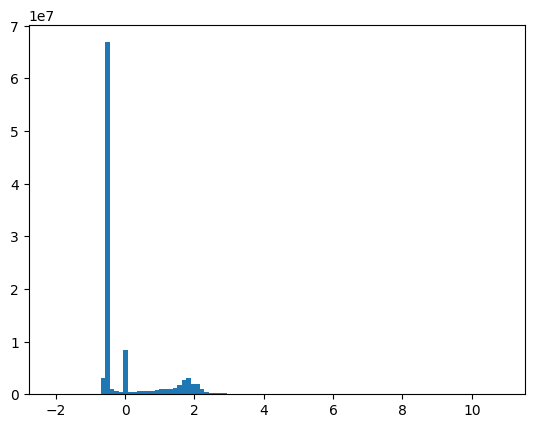

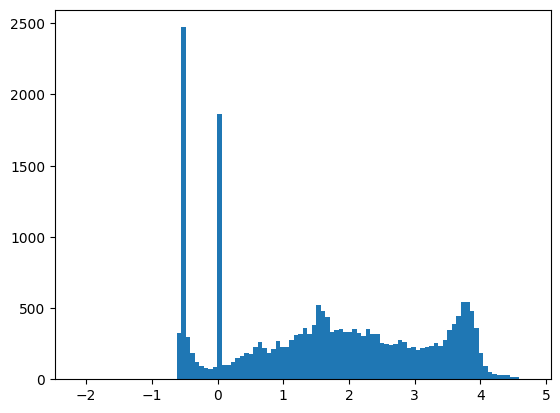

In [10]:
# np.sum(ppe_sim_train['vals'] > y_thresholds)
# test = np.log10(tgt_sim['vals'][0,7204:10804])
# test_finite = test[np.isfinite(test)]
a = 0
# ytrue = tgt_sim['vals'][:,a+6:a+3606]
# ytrue[~np.isfinite(ytrue)] = np.nan
# plt.hist(ytrue.flatten())
# plt.figure()
# plt.hist(y_all[:,5:65].flatten(), bins=100)
# plt.figure()
# plt.hist(tgt_all[:,5:65].flatten(), bins=100)

plt.hist(ppe_all[:,a+4:a+3604].flatten(), bins=100)
plt.figure()
plt.hist(tgt_all[:,a+4:a+3604].flatten(), bins=100)

In [11]:
np.mean(tgt_all[0,a+4:a+3604])

np.float64(-0.30213644517909577)

## multi-output model

In [ ]:
proj_name = 'try3_rainshaft_M3069'
tuner = kt.RandomSearch(
    lambda hp: tu.build_classreg_model(hp, npar, nobs),
    objective="val_loss",
    max_trials=100,
    directory='/pscratch/sd/a/arthurhu/BOSS_PPE/hp_tuning_withclass/multi-output',
    project_name=proj_name,
)


stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(
    x_train,
    {'presence': y_train_wpresence, 'water': y_train},
    epochs=50,
    validation_data=(x_val, {'presence': y_val_wpresence, 'water': y_val}),
    callbacks=([stop_early])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)



Trial 29 Complete [00h 05m 26s]
val_loss: 0.41260620951652527

Best val_loss So Far: 0.3494957685470581
Total elapsed time: 01h 49m 25s

Search: Running Trial #30

Value             |Best Value So Far |Hyperparameter
4                 |5                 |num_shared_layers
96                |192               |units_0
sgd               |adam              |optimizer
1.638e-05         |0.0014865         |adam_lr
224               |224               |units_1
96                |256               |units_2
32                |256               |units_3
0.0006145         |6.4312e-05        |rmsprop_lr
96                |192               |units_4
2.3274e-06        |4.4645e-05        |sgd_lr
0.2               |0.4               |sgd_momentum

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.6161 - presence_accuracy: 0.0000e+00 - presence_loss: 0.6931 - water_loss: 0.9230 - water_mae: 0.7322 - val_loss: 1.6376 - val_presence_accuracy: 0.0000e+00 - val_presence_loss: 0.6931 - val_wa

In [16]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │      3,968 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 160)       │     10,400 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence (Dense)    │ (None, 14404)     │  2,319,044 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ water (Dense)       │ (None, 14404)     │  2,319,044 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,660,712 (17.78 MB)

 Trainable params: 4,660,712 (17.78 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# stop_early = keras.callbacks.EarlyStopping(monitor='val_presence_accuracy', mode='max', patience=2000)

train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, {'presence': y_train_wpresence, 'water': y_train}))
                 .shuffle(buffer_size=len(x_train))
                 .cache()
                 .batch(32)
                 .prefetch(tf.data.AUTOTUNE))

val_dataset = (tf.data.Dataset.from_tensor_slices((x_val, {'presence': y_val_wpresence, 'water': y_val}))
               .cache()
               .batch(32)
               .prefetch(tf.data.AUTOTUNE))

history = best_model.fit(
    train_dataset,
    epochs=15000,
    verbose=0,
    validation_data=val_dataset,
    callbacks=[TqdmCallback(verbose=1)]
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

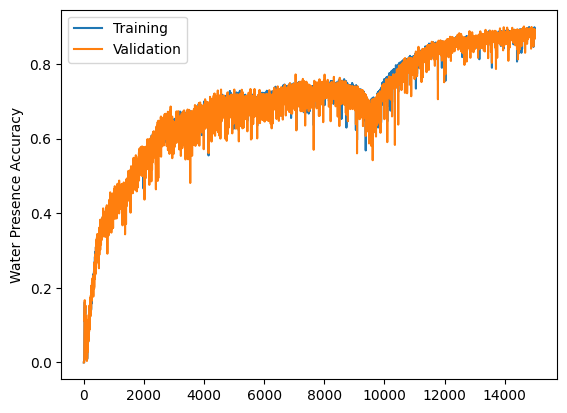

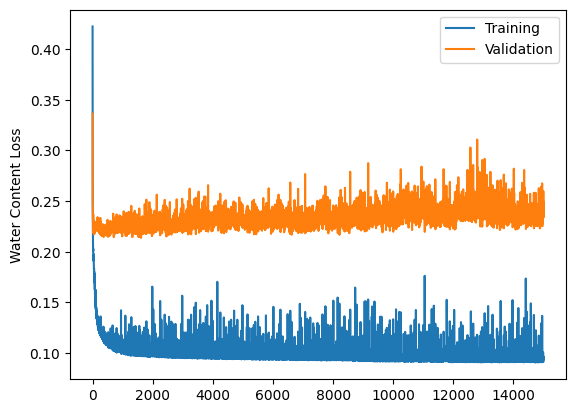

In [18]:
plt.figure()
plt.plot(history.epoch, history.history['presence_accuracy'], label='Training')
plt.plot(history.epoch, history.history['val_presence_accuracy'], label='Validation')
plt.ylabel('Water Presence Accuracy')
plt.legend()

plt.figure()
plt.plot(history.epoch, history.history['water_loss'], label='Training')
plt.plot(history.epoch, history.history['val_water_loss'], label='Validation')
plt.ylabel('Water Content Loss')
plt.legend()

In [19]:
# save model:
best_model.save('/pscratch/sd/a/arthurhu/BOSS_PPE/models/multioutput_' + proj_name + '.keras')

## validation

In [ ]:
# best_model = tf.keras.models.load_model('models/multioutput_try28_condcoll_fullmom_nopartition_asinh.keras', compile=False)
plt.plot(best_model(x_val)[1][:, 0])
# cc_model(x_val)[1]

In [ ]:
plt.plot(y_val[:,0])

In [ ]:
y_pred = standscale.inverse_transform(best_model(x_val)[1].numpy())
# y_pred = model(x_val)
plt.plot(y_pred[:,0])

In [ ]:
standscale.inverse_transform(y_train)

In [ ]:
np.mean(y_pred[:, 0]), np.mean(standscale.inverse_transform(y_train)[:, 0])

In [ ]:
y_pred.shape

In [ ]:
y_pred = standscale.inverse_transform(best_model(x_val)[1].numpy())
# y_pred = standscale.inverse_transform(model(x_val).numpy())
# y_pred = np.exp(standscale.inverse_transform(model(x_val).numpy()))
y_val_lin = standscale.inverse_transform(y_val)
# y_train_lin = np.exp(standscale.inverse_transform(y_train))

fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(1,4)
for i in range(len(eff0)):
    ax = fig.add_subplot(gs[i])
    ax.set_aspect('equal')
    plt.scatter(y_val_lin[:,i], y_pred[:,i], alpha=0.05,c='k')
    # plt.scatter(ppe_sim_valid['vals'][:,i], y_pred[:,i],alpha=0.2,c='k')
    # plt.scatter(y_val[:,i], y_pred[:,i],alpha=0.2,c='k')
    plt.title(ppe_sim_train['var_names'][i])
    ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
    ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
    plt.plot([ax_min, ax_max], [ax_min, ax_max])
    # ax.set_xscale('log')
    # ax.set_yscale('log')
# fig.tight_layout()
# plt.savefig(plot_dir + proj_name + '.png')